<a href="https://colab.research.google.com/github/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Necessarry Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use("seaborn-darkgrid")

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnext50_32x4d
from torch.optim import Adam, AdamW, lr_scheduler

from tqdm import trange
import os
import albumentations as albu
import cv2
import glob

In [4]:
from classes import *
from functions import *


## Switch between CPU and cuda

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load Data

In [6]:
classes = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

In [7]:
data_images = np.load('/content/drive/My Drive/Brain-Tumor-Segmentation-Project/brain_tumor_dataset/images.npy', allow_pickle=True)
data_labels = np.load('/content/drive/My Drive/Brain-Tumor-Segmentation-Project/brain_tumor_dataset/labels.npy', allow_pickle=True)
data_masks = np.load('/content/drive/My Drive/Brain-Tumor-Segmentation-Project/brain_tumor_dataset/masks.npy', allow_pickle=True)
print(" Shapes:\n Images:",data_images.shape, "Masks:", data_masks.shape, "Labels:", data_labels.shape)

 Shapes:
 Images: (3064,) Masks: (3064,) Labels: (3064,)


In [8]:
data = np.column_stack((data_images, data_masks, data_labels))

## Split the data into train, test and validation sets

In [9]:
train_data, test_data = train_test_split(data, test_size = 0.1, random_state=123)
train_data, val_data = train_test_split(train_data, test_size = 0.111, random_state=123)
print(len(train_data),len(test_data), len(val_data) )


2450 307 307


## Define the transformations in the images

In [10]:
transforms = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, 
                       border_mode=0),
                        
    albu.GridDistortion(p=0.5),
    albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    albu.Resize(156, 156, p=1.),
    albu.RandomCrop(128, 128, p=1.)
    ])

## Define datasets and data loaders

In [11]:
train_dataset = BrainMRI(data=train_data, transforms=transforms)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)

val_dataset = BrainMRI(data=val_data, transforms=transforms)
val_data_loader = DataLoader(val_dataset, batch_size=8, num_workers=2, shuffle=True)

test_dataset = BrainMRI(data=test_data, transforms=transforms)
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, shuffle=False)

## Download the pretrained Resnext model 

In [12]:
base_model = resnext50_32x4d(pretrained=True)

In [13]:
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [14]:
model = ResNeXtUNet(n_classes=3).to(device)
adam = AdamW(model.parameters(), lr=5e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = lr_scheduler.StepLR(adam, step_size=10, gamma=0.1)

## Train the model

In [15]:
#Measure the training time
%%time 
#Make a folder to save weights
weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)

#Determine epochs
num_epochs = 50


#Initialize lists
loss_history = []
train_dice_history = []
val_dice_history = []

#Start training
for epoch in trange(num_epochs):
    loss, train_dice = train_one_epoch(model, adam, scheduler, 
                                       train_data_loader, epoch)
    
    val_dice = valscore = val_epoch(model, val_data_loader, epoch)

    # Save train history
    loss_history.append(loss)
    train_dice_history.append(train_dice)
    val_dice_history.append(val_dice)

    # Save best weights
    best_dice = max(val_dice_history)
    if val_dice >= best_dice:
        torch.save({'state_dict': model.state_dict()},
                   os.path.join(weights_dir, f"{val_dice:0.5f}_.pth"))


  0%|          | 0/50 [00:00<?, ?it/s]

Start Train ...
Epoch [0]
Mean loss on train: 0.8754951660718514 Mean DICE on train: 0.21735410613110517
Start Validation ...
Epoch:  0  Threshold:  0.33 Mean DICE on validation: 0.37352888533164874


  2%|▏         | 1/50 [03:44<3:03:06, 224.21s/it]

Start Train ...
Epoch [1]
Mean loss on train: 0.6441478343856452 Mean DICE on train: 0.42975776197774374
Start Validation ...
Epoch:  1  Threshold:  0.33 Mean DICE on validation: 0.4928362621055726


  4%|▍         | 2/50 [07:28<2:59:17, 224.11s/it]

Start Train ...
Epoch [2]
Mean loss on train: 0.5213758358155477 Mean DICE on train: 0.5512653444129694
Start Validation ...
Epoch:  2  Threshold:  0.33 Mean DICE on validation: 0.6144490322692848


  6%|▌         | 3/50 [11:11<2:55:26, 223.96s/it]

Start Train ...
Epoch [3]
Mean loss on train: 0.5072668891290888 Mean DICE on train: 0.5581818419179468
Start Validation ...


  8%|▊         | 4/50 [14:55<2:51:36, 223.83s/it]

Epoch:  3  Threshold:  0.33 Mean DICE on validation: 0.5747017237253962
Start Train ...
Epoch [4]
Mean loss on train: 0.45470628613175323 Mean DICE on train: 0.5991370620476791
Start Validation ...


 10%|█         | 5/50 [18:38<2:47:50, 223.79s/it]

Epoch:  4  Threshold:  0.33 Mean DICE on validation: 0.5875516999669659
Start Train ...
Epoch [5]
Mean loss on train: 0.44316863625368 Mean DICE on train: 0.6078919945774909
Start Validation ...


 12%|█▏        | 6/50 [22:22<2:44:06, 223.78s/it]

Epoch:  5  Threshold:  0.33 Mean DICE on validation: 0.5978847724477332
Start Train ...
Epoch [6]
Mean loss on train: 0.459567653482434 Mean DICE on train: 0.5943361674955832
Start Validation ...


 14%|█▍        | 7/50 [26:06<2:40:26, 223.88s/it]

Epoch:  6  Threshold:  0.33 Mean DICE on validation: 0.6337472919931199
Start Train ...
Epoch [7]
Mean loss on train: 0.4371932882585044 Mean DICE on train: 0.604793070783313
Start Validation ...


 16%|█▌        | 8/50 [29:50<2:36:44, 223.91s/it]

Epoch:  7  Threshold:  0.33 Mean DICE on validation: 0.6047301043556192
Start Train ...
Epoch [8]
Mean loss on train: 0.41902731608975596 Mean DICE on train: 0.6325100085777438
Start Validation ...


 18%|█▊        | 9/50 [33:34<2:33:00, 223.92s/it]

Epoch:  8  Threshold:  0.33 Mean DICE on validation: 0.583923479698567
Start Train ...
Epoch [9]
Mean loss on train: 0.40328297696109705 Mean DICE on train: 0.6469911493210279
Start Validation ...
Epoch:  9  Threshold:  0.33 Mean DICE on validation: 0.6475438718203067


 20%|██        | 10/50 [37:18<2:29:18, 223.95s/it]

Start Train ...
Epoch [10]
Mean loss on train: 0.33421690084938116 Mean DICE on train: 0.7035482923568218
Start Validation ...
Epoch:  10  Threshold:  0.33 Mean DICE on validation: 0.6866107037898431


 22%|██▏       | 11/50 [41:02<2:25:31, 223.88s/it]

Start Train ...
Epoch [11]
Mean loss on train: 0.3145268433985182 Mean DICE on train: 0.7186459874996184
Start Validation ...
Epoch:  11  Threshold:  0.33 Mean DICE on validation: 0.7056049028142305


 24%|██▍       | 12/50 [44:46<2:21:46, 223.86s/it]

Start Train ...
Epoch [12]
Mean loss on train: 0.30653809787590264 Mean DICE on train: 0.7305367003880059
Start Validation ...
Epoch:  12  Threshold:  0.33 Mean DICE on validation: 0.7322971291818526


 26%|██▌       | 13/50 [48:30<2:18:02, 223.85s/it]

Start Train ...
Epoch [13]
Mean loss on train: 0.30166524304046693 Mean DICE on train: 0.7379335506385678
Start Validation ...


 28%|██▊       | 14/50 [52:13<2:14:17, 223.81s/it]

Epoch:  13  Threshold:  0.33 Mean DICE on validation: 0.7113498043432452
Start Train ...
Epoch [14]
Mean loss on train: 0.30065030946793697 Mean DICE on train: 0.7398089052838802
Start Validation ...


 30%|███       | 15/50 [55:57<2:10:29, 223.69s/it]

Epoch:  14  Threshold:  0.33 Mean DICE on validation: 0.6924874722913437
Start Train ...
Epoch [15]
Mean loss on train: 0.2936002325011775 Mean DICE on train: 0.7418612839044402
Start Validation ...


 32%|███▏      | 16/50 [59:40<2:06:45, 223.70s/it]

Epoch:  15  Threshold:  0.33 Mean DICE on validation: 0.7238881070383785
Start Train ...
Epoch [16]
Mean loss on train: 0.2949719339948912 Mean DICE on train: 0.7428500953469634
Start Validation ...
Epoch:  16  Threshold:  0.33 Mean DICE on validation: 0.7400353312843236


 34%|███▍      | 17/50 [1:03:25<2:03:06, 223.83s/it]

Start Train ...
Epoch [17]
Mean loss on train: 0.27753310046289176 Mean DICE on train: 0.7517849158201068
Start Validation ...
Epoch:  17  Threshold:  0.33 Mean DICE on validation: 0.741174915193751


 36%|███▌      | 18/50 [1:07:09<1:59:23, 223.86s/it]

Start Train ...
Epoch [18]
Mean loss on train: 0.2822499680256999 Mean DICE on train: 0.7594819019340371
Start Validation ...


 38%|███▊      | 19/50 [1:10:52<1:55:38, 223.81s/it]

Epoch:  18  Threshold:  0.33 Mean DICE on validation: 0.7369742612345203
Start Train ...
Epoch [19]
Mean loss on train: 0.2769905180709758 Mean DICE on train: 0.753713290000415
Start Validation ...


 40%|████      | 20/50 [1:14:36<1:51:54, 223.80s/it]

Epoch:  19  Threshold:  0.33 Mean DICE on validation: 0.7343899178865118
Start Train ...
Epoch [20]
Mean loss on train: 0.2693796722090982 Mean DICE on train: 0.7652386571180742
Start Validation ...


 42%|████▏     | 21/50 [1:18:20<1:48:09, 223.77s/it]

Epoch:  20  Threshold:  0.33 Mean DICE on validation: 0.7238588719572616
Start Train ...
Epoch [21]
Mean loss on train: 0.2744048535338442 Mean DICE on train: 0.7607267960154938
Start Validation ...


 44%|████▍     | 22/50 [1:22:04<1:44:28, 223.88s/it]

Epoch:  21  Threshold:  0.33 Mean DICE on validation: 0.7436092616860475
Start Train ...
Epoch [22]
Mean loss on train: 0.2723797259530726 Mean DICE on train: 0.7570321413910331
Start Validation ...
Epoch:  22  Threshold:  0.33 Mean DICE on validation: 0.745038942624704


 46%|████▌     | 23/50 [1:25:48<1:40:45, 223.91s/it]

Start Train ...
Epoch [23]
Mean loss on train: 0.2719033293013464 Mean DICE on train: 0.7579762309770882
Start Validation ...
Epoch:  23  Threshold:  0.33 Mean DICE on validation: 0.74942594738204


 48%|████▊     | 24/50 [1:29:33<1:37:08, 224.19s/it]

Start Train ...
Epoch [24]
Mean loss on train: 0.27168144154626306 Mean DICE on train: 0.760670102142224
Start Validation ...
Epoch:  24  Threshold:  0.33 Mean DICE on validation: 0.7591749484272785


 50%|█████     | 25/50 [1:33:17<1:33:26, 224.25s/it]

Start Train ...
Epoch [25]
Mean loss on train: 0.2681135102281353 Mean DICE on train: 0.7622175420307947
Start Validation ...


 52%|█████▏    | 26/50 [1:37:01<1:29:39, 224.14s/it]

Epoch:  25  Threshold:  0.33 Mean DICE on validation: 0.7259111419698872
Start Train ...
Epoch [26]
Mean loss on train: 0.2680779188531618 Mean DICE on train: 0.7637674181581948
Start Validation ...


 54%|█████▍    | 27/50 [1:40:45<1:25:52, 224.03s/it]

Epoch:  26  Threshold:  0.33 Mean DICE on validation: 0.7425247575872463
Start Train ...
Epoch [27]
Mean loss on train: 0.2685903121720308 Mean DICE on train: 0.7648267652898967
Start Validation ...


 56%|█████▌    | 28/50 [1:44:29<1:22:08, 224.01s/it]

Epoch:  27  Threshold:  0.33 Mean DICE on validation: 0.7471405677626003
Start Train ...
Epoch [28]
Mean loss on train: 0.2610031732081979 Mean DICE on train: 0.7675132228245614
Start Validation ...


 58%|█████▊    | 29/50 [1:48:13<1:18:23, 223.99s/it]

Epoch:  28  Threshold:  0.33 Mean DICE on validation: 0.7390745522378155
Start Train ...
Epoch [29]
Mean loss on train: 0.2692391133415194 Mean DICE on train: 0.7621261838876929
Start Validation ...


 60%|██████    | 30/50 [1:51:57<1:14:40, 224.03s/it]

Epoch:  29  Threshold:  0.33 Mean DICE on validation: 0.740450908117441
Start Train ...
Epoch [30]
Mean loss on train: 0.27363255469534997 Mean DICE on train: 0.7624369225670359
Start Validation ...


 62%|██████▏   | 31/50 [1:55:41<1:10:55, 223.98s/it]

Epoch:  30  Threshold:  0.33 Mean DICE on validation: 0.7374530542639012
Start Train ...
Epoch [31]
Mean loss on train: 0.2670221206905011 Mean DICE on train: 0.7649428976753783
Start Validation ...


 64%|██████▍   | 32/50 [1:59:24<1:07:10, 223.90s/it]

Epoch:  31  Threshold:  0.33 Mean DICE on validation: 0.7357824119498568
Start Train ...
Epoch [32]
Mean loss on train: 0.26715403122991227 Mean DICE on train: 0.7628344851493688
Start Validation ...


 66%|██████▌   | 33/50 [2:03:08<1:03:25, 223.86s/it]

Epoch:  32  Threshold:  0.33 Mean DICE on validation: 0.7365417321632152
Start Train ...
Epoch [33]
Mean loss on train: 0.2630720271786572 Mean DICE on train: 0.7682091852893577
Start Validation ...


 68%|██████▊   | 34/50 [2:06:52<59:42, 223.91s/it]  

Epoch:  33  Threshold:  0.33 Mean DICE on validation: 0.7590922130897215
Start Train ...
Epoch [34]
Mean loss on train: 0.26630008909911984 Mean DICE on train: 0.7687703534811323
Start Validation ...


 70%|███████   | 35/50 [2:10:36<55:59, 223.97s/it]

Epoch:  34  Threshold:  0.33 Mean DICE on validation: 0.7399627220934014
Start Train ...
Epoch [35]
Mean loss on train: 0.2633386234167344 Mean DICE on train: 0.7688989868602732
Start Validation ...


 72%|███████▏  | 36/50 [2:14:20<52:14, 223.90s/it]

Epoch:  35  Threshold:  0.33 Mean DICE on validation: 0.7393978519629194
Start Train ...
Epoch [36]
Mean loss on train: 0.266679119986121 Mean DICE on train: 0.7651490040588782
Start Validation ...


 74%|███████▍  | 37/50 [2:18:04<48:30, 223.92s/it]

Epoch:  36  Threshold:  0.33 Mean DICE on validation: 0.7476544051286468
Start Train ...
Epoch [37]
Mean loss on train: 0.27407575913186183 Mean DICE on train: 0.7654864636781459
Start Validation ...


 76%|███████▌  | 38/50 [2:21:48<44:47, 223.94s/it]

Epoch:  37  Threshold:  0.33 Mean DICE on validation: 0.7390143192452748
Start Train ...
Epoch [38]
Mean loss on train: 0.2589876378252374 Mean DICE on train: 0.7682782328300829
Start Validation ...


 78%|███████▊  | 39/50 [2:25:32<41:03, 223.95s/it]

Epoch:  38  Threshold:  0.33 Mean DICE on validation: 0.748241449055876
Start Train ...
Epoch [39]
Mean loss on train: 0.26497003984567785 Mean DICE on train: 0.7687889500730138
Start Validation ...


 80%|████████  | 40/50 [2:29:16<37:20, 224.03s/it]

Epoch:  39  Threshold:  0.33 Mean DICE on validation: 0.7241491603938603
Start Train ...
Epoch [40]
Mean loss on train: 0.25611429435810745 Mean DICE on train: 0.7749657805181575
Start Validation ...


 82%|████████▏ | 41/50 [2:33:01<33:37, 224.14s/it]

Epoch:  40  Threshold:  0.33 Mean DICE on validation: 0.7385829281925842
Start Train ...
Epoch [41]
Mean loss on train: 0.26702889632615673 Mean DICE on train: 0.7640935830019945
Start Validation ...


 84%|████████▍ | 42/50 [2:36:44<29:52, 224.02s/it]

Epoch:  41  Threshold:  0.33 Mean DICE on validation: 0.7314355659737536
Start Train ...
Epoch [42]
Mean loss on train: 0.2649134117442544 Mean DICE on train: 0.767504059896059
Start Validation ...


 86%|████████▌ | 43/50 [2:40:28<26:08, 224.03s/it]

Epoch:  42  Threshold:  0.33 Mean DICE on validation: 0.7543565445303907
Start Train ...
Epoch [43]
Mean loss on train: 0.26233276894698315 Mean DICE on train: 0.7726219552019886
Start Validation ...


 88%|████████▊ | 44/50 [2:44:13<22:24, 224.15s/it]

Epoch:  43  Threshold:  0.33 Mean DICE on validation: 0.7265447256913348
Start Train ...
Epoch [44]
Mean loss on train: 0.2628645660531637 Mean DICE on train: 0.7748163922854546
Start Validation ...


 90%|█████████ | 45/50 [2:47:57<18:40, 224.12s/it]

Epoch:  44  Threshold:  0.33 Mean DICE on validation: 0.7348239296373621
Start Train ...
Epoch [45]
Mean loss on train: 0.2697526967146886 Mean DICE on train: 0.763199056494883
Start Validation ...


 92%|█████████▏| 46/50 [2:51:40<14:55, 223.98s/it]

Epoch:  45  Threshold:  0.33 Mean DICE on validation: 0.7395027282678033
Start Train ...
Epoch [46]
Mean loss on train: 0.265967163933799 Mean DICE on train: 0.7617006163857424
Start Validation ...
Epoch:  46  Threshold:  0.33 Mean DICE on validation: 0.768632780331432


 94%|█████████▍| 47/50 [2:55:24<11:11, 223.96s/it]

Start Train ...
Epoch [47]
Mean loss on train: 0.2665395814719146 Mean DICE on train: 0.7669277911861697
Start Validation ...


 96%|█████████▌| 48/50 [2:59:08<07:27, 223.92s/it]

Epoch:  47  Threshold:  0.33 Mean DICE on validation: 0.7338572302745453
Start Train ...
Epoch [48]
Mean loss on train: 0.2634863536744242 Mean DICE on train: 0.7698004294606243
Start Validation ...


 98%|█████████▊| 49/50 [3:02:52<03:43, 223.90s/it]

Epoch:  48  Threshold:  0.33 Mean DICE on validation: 0.7270019771049648
Start Train ...
Epoch [49]
Mean loss on train: 0.2619689825303391 Mean DICE on train: 0.7722775082090303
Start Validation ...


100%|██████████| 50/50 [3:06:36<00:00, 223.93s/it]

Epoch:  49  Threshold:  0.33 Mean DICE on validation: 0.7410646393449971
CPU times: user 1h 50min 29s, sys: 1h 6min 34s, total: 2h 57min 3s
Wall time: 3h 6min 36s


## Load the best weights

In [16]:
# Load the best weights
best_weights =  sorted(glob.glob(weights_dir + "/*"),
                       key= lambda x: x[8:-5])[-1]
checkpoint = torch.load(best_weights)
model.load_state_dict(checkpoint['state_dict'])
#Print the loaded model
print(f'Loaded model: {best_weights.split("/")[1]}')

Loaded model: 0.76863_.pth


## Plot training history

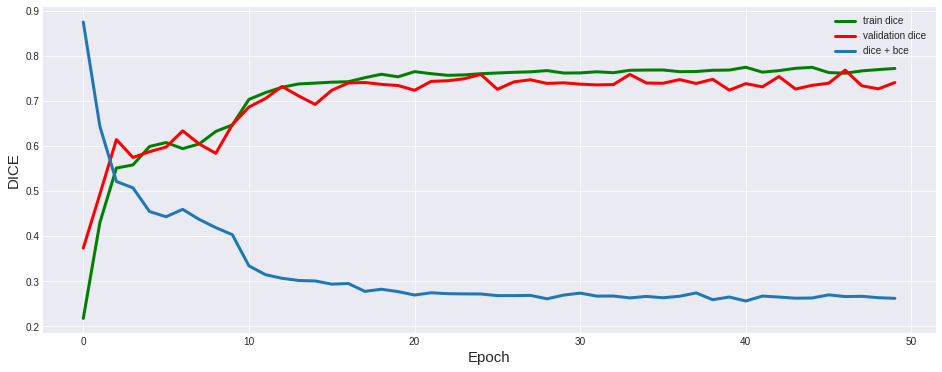

In [17]:
plot_history(train_dice_history, val_dice_history, loss_history, num_epochs)

In [18]:
test_iou = val_epoch(model, test_data_loader, epoch=None, threshold=0.5)
print(f"""Mean IoU of the test images - {np.around(test_iou, 2)*100}%""")

Start Test...
Epoch:  None  Threshold:  0.5 Mean DICE on validation: 0.7478172060691292
Mean IoU of the test images - 75.0%


In [19]:
dices = []
thresholds = [0.1, 0.2, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.88]
for i in thresholds:
    test_dice = val_epoch(model, test_data_loader,threshold=i, epoch=None)
    dices.append(test_dice)


Start Test...
Epoch:  None  Threshold:  0.1 Mean DICE on validation: 0.7535127673443828
Start Test...
Epoch:  None  Threshold:  0.2 Mean DICE on validation: 0.7483621079246398
Start Test...
Epoch:  None  Threshold:  0.33 Mean DICE on validation: 0.7333990225124623
Start Test...
Epoch:  None  Threshold:  0.4 Mean DICE on validation: 0.7417938142537117
Start Test...
Epoch:  None  Threshold:  0.5 Mean DICE on validation: 0.7539893740744323
Start Test...
Epoch:  None  Threshold:  0.6 Mean DICE on validation: 0.755226029888072
Start Test...
Epoch:  None  Threshold:  0.7 Mean DICE on validation: 0.7391265277410279
Start Test...
Epoch:  None  Threshold:  0.8 Mean DICE on validation: 0.7201747248002344
Start Test...
Epoch:  None  Threshold:  0.85 Mean DICE on validation: 0.7602732352011904
Start Test...
Epoch:  None  Threshold:  0.88 Mean DICE on validation: 0.728473986599554


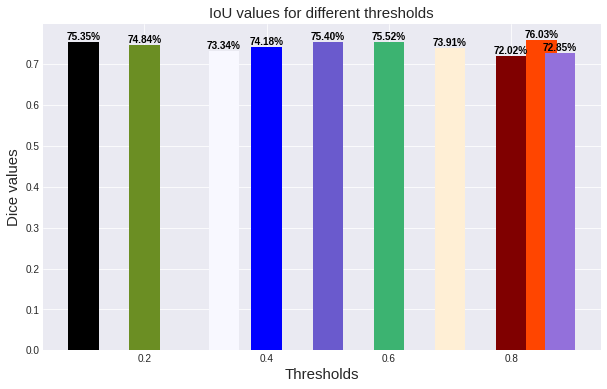

In [20]:
colors = random.choices(list(mcolors.CSS4_COLORS.keys()),k=len(thresholds))

plt.figure(figsize=(10,6))
plt.bar(thresholds, dices, width=0.05, color=colors)
plt.ylabel("Dice values", fontsize=15)
plt.xlabel("Thresholds", fontsize=15)
plt.title("IoU values for different thresholds", fontsize=15)


# Annotate
for row, value in zip(thresholds, dices):
    plt.annotate(f"{value*100:0.2f}%", xy=(row, value), 
                 rotation=0, color="black", 
                 ha="center", verticalalignment='bottom', 
                 fontsize=10, fontweight="bold")

In [21]:
#Predict
test_predictions = []
test_ground_truths = []
for data, target in test_data_loader:
    with torch.no_grad():
        data = data.permute(0,3,1,2).to(device)
        target = target.permute(0,3,1,2)
        prediction = model(data)

        #Append the predictions to the list 
        test_predictions.append(prediction.detach().cpu())
        test_ground_truths.append(target)

# Change the Python list to Pytorch tensor 
test_predictions = torch.cat(test_predictions)
test_ground_truths = torch.cat(test_ground_truths)

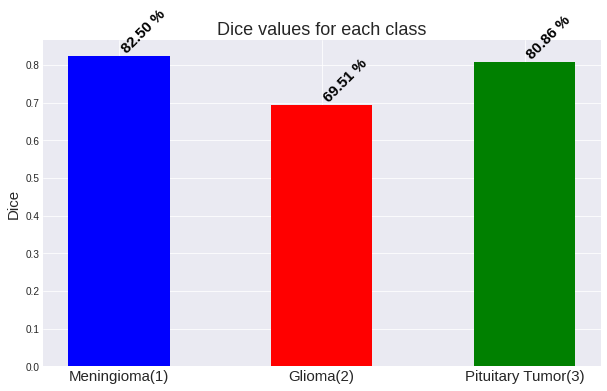

In [22]:
# data
dice_meningioma = dice_metric(test_predictions[:,0,:,:], test_ground_truths[:,0,:,:])
dice_glioma = dice_metric(test_predictions[:,1,:,:], test_ground_truths[:,1,:,:])
dice_pituitary = dice_metric(test_predictions[:,2,:,:], test_ground_truths[:,2,:,:])
dice_values = [dice_meningioma, dice_glioma, dice_pituitary ]

# x axis is the 3 classes
x = [1, 2, 3]

# Plot the dice values

plt.figure(figsize=(10, 6))
plt.bar(x, dice_values, 
        color=["blue", "red", "green"], width=0.5)                                        
plt.xticks(x, ['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'], fontsize=15)
plt.ylabel("Dice", fontsize=15)
plt.title("Dice values for each class", fontsize=18)


# Annotate the dice values
for row, value in zip(x, dice_values):
    plt.annotate(f"{value*100:0.2f} %", xy=(row, value), 
                 rotation=45, color="black", 
                  verticalalignment='bottom', 
                 fontsize=15, fontweight="bold")
    
plt.show()

Choose a random image from the test data and compare the ground truth and prediction for the same sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


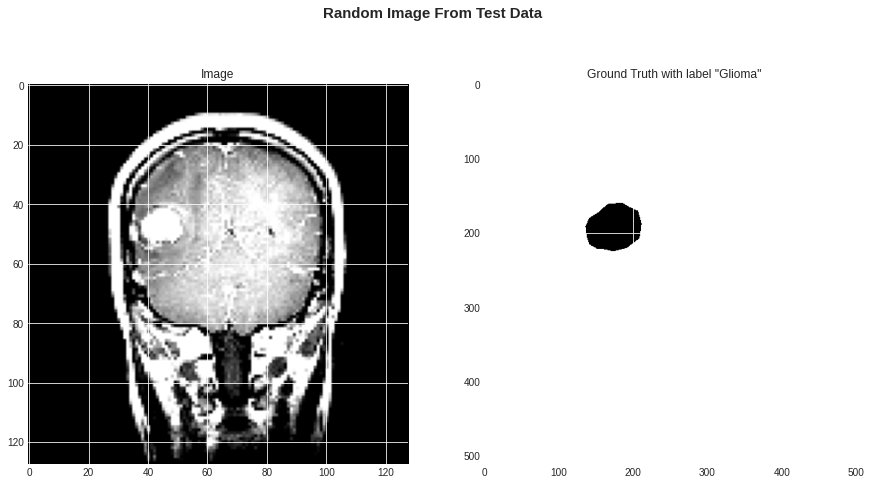

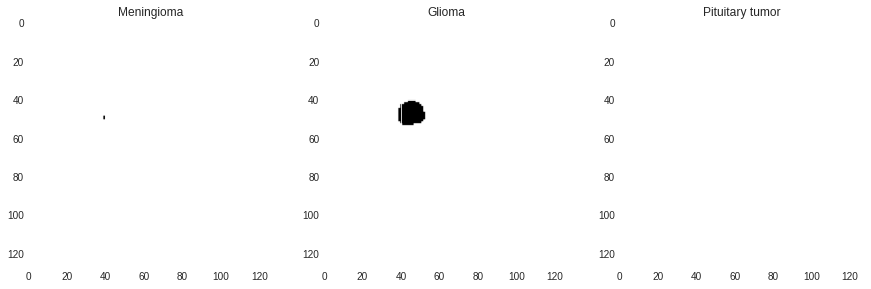

In [23]:
# Random index from the test data
index = np.random.choice(test_data.shape[0], 1, replace=False)

# Image for this index
test_image = test_data[index][0][0]

# Standardize the piksels
mean, std = test_image.mean(), test_image.std()
test_image = (test_image - mean) / std  
test_image = cv2.resize(test_image, (128, 128))
# Convert to rgb
test_image = np.stack([test_image]*3).transpose(1,2,0)

# Mask of the same sample
test_mask = test_data[index][0][1]

# Label of the same sample
test_label = test_data[index][0][2]

# Predict
preds = torch.tensor(test_image.astype(np.float32)).unsqueeze(0).permute(0,3,1,2)
preds = model(preds.to(device))

preds = preds.detach().cpu().numpy()

# Apply threshold
preds[np.nonzero(preds < 0.4)] = 0.0
preds[np.nonzero(preds >= 0.4)] = 255.#1.0
preds = preds.astype("uint8")

pred1 = preds[:,0,:,:]
pred2 = preds[:,1,:,:]
pred3 = preds[:,2,:,:]

# Plot the data
fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(15, 15))

ax[0].imshow(test_image)
ax[0].set_title("Image")
ax[1].imshow(test_mask)
ax[1].set_title(f'Ground Truth with label "{classes[test_label].capitalize()}"')

# title
plt.suptitle("Random Image From Test Data",
             y=.75, fontsize=15, weight="bold")

# plot the prediction
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(15, 30))

ax[0].imshow(pred1[0,:,:])
ax[0].set_title(f'{classes[1].capitalize()}')
ax[1].imshow(pred2[0,:,:])
ax[1].set_title(f'{classes[2].capitalize()}')
ax[2].imshow(pred3[0,:,:])
ax[2].set_title(f'{classes[3].capitalize()}');
